<a href="https://colab.research.google.com/github/zhursvlevy/coursework/blob/main/videoclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Conv2D, Masking, RNN, Input
from keras.metrics import Accuracy, AUC, Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, roc_curve, ConfusionMatrixDisplay,
                            RocCurveDisplay, plot_confusion_matrix, auc, precision_recall_curve, PrecisionRecallDisplay)

# Создание API для предобработки датасета. Датасет взян с сайта: https://github.com/Cogito2012/CarCrashDataset

In [2]:
# чтение текстового файла с аннотациями к видео
def read_anno_file(anno_file):
    assert os.path.exists(anno_file), "Annotation file does not exist!" + anno_file
    result = []
    with open(anno_file, 'r') as f:
        for line in f.readlines():
            items = {}
            items['vid'] = line.strip().split(',[')[0]
            labels = line.strip().split(',[')[1].split('],')[0]
            items['label'] = [int(val) for val in labels.split(',')]
            others = line.strip().split(',[')[1].split('],')[1].split(',')
            items['startframe'], items['vid_ytb'], items['lighting'], items['weather'], items['ego_involve'] = others
            result.append(items)
    f.close()
    return result
 
 # чтение видео и его преобразование в последовательность трехканальных кадров  
def get_video_frames(video_file, topN=50, shape : tuple=None, step=None):
 
    cap = cv2.VideoCapture(video_file)
    # cap.set(cv2.CAP_PROP_FPS, 15)
    # print(cap.get(cv2.CAP_PROP_FPS))

    ret, frame = cap.read()
    video_data = []
    count = 1
    while (ret):
        if not isinstance(shape, type(None)):
            try:
                frame = cv2.resize(frame, shape, interpolation=cv2.INTER_AREA)
            except:
                break
        
        if not isinstance(step, type(None)):
            count += step
            # cap.set(1, count)
        video_data.append(frame)
        ret, frame = cap.read()
        
    # print("original # frames: %d"%(len(video_data)))
    # assert len(video_data) >= topN
    video_data = video_data[:topN]
    return video_data
 
 #извлечение только кадров с аномалией
def get_accident_frames_only(frames, temporal_annotation):
 
    ind = temporal_annotation.index(1)
    return np.array(frames[ind:])

def load_features(path, num_of_features=1000):

    feature_list = []
    with open(path, 'rb') as feat_file:
        try:
            for i in range(num_of_features):
                feature_list.append(np.load(feat_file))
        except:
            print('EOF')
    return np.array(feature_list, dtype=np.object)

# Рекуррентная нейронная сеть с независимыми слоями (код одной ячейки indrnncell). Взято с сайта: https://github.com/batzner/indrnn

In [3]:
"""Module implementing the IndRNN cell"""

from tensorflow.python.ops import math_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.layers import base as base_layer

try:
  # TF 1.7+
  from tensorflow.python.ops.rnn_cell_impl import LayerRNNCell
except ImportError:
  from tensorflow.python.ops.rnn_cell_impl import _LayerRNNCell as LayerRNNCell


class IndRNNCell(LayerRNNCell):
  """Independently RNN Cell. Adapted from `rnn_cell_impl.BasicRNNCell`.
  Each unit has a single recurrent weight connected to its last hidden state.
  The implementation is based on:
    https://arxiv.org/abs/1803.04831
  Shuai Li, Wanqing Li, Chris Cook, Ce Zhu, Yanbo Gao
  "Independently Recurrent Neural Network (IndRNN): Building A Longer and
  Deeper RNN"
  The default initialization values for recurrent weights, input weights and
  biases are taken from:
    https://arxiv.org/abs/1504.00941
  Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
  "A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
  Args:
    num_units: int, The number of units in the RNN cell.
    recurrent_min_abs: float, minimum absolute value of each recurrent weight.
    recurrent_max_abs: (optional) float, maximum absolute value of each
      recurrent weight. For `relu` activation, `pow(2, 1/timesteps)` is
      recommended. If None, recurrent weights will not be clipped.
      Default: None.
    recurrent_kernel_initializer: (optional) The initializer to use for the
      recurrent weights. If None, every recurrent weight is initially set to 1.
      Default: None.
    input_kernel_initializer: (optional) The initializer to use for the input
      weights. If None, the input weights are initialized from a random normal
      distribution with `mean=0` and `stddev=0.001`. Default: None.
    activation: Nonlinearity to use.  Default: `relu`.
    reuse: (optional) Python boolean describing whether to reuse variables
      in an existing scope.  If not `True`, and the existing scope already has
      the given variables, an error is raised.
    name: String, the name of the layer. Layers with the same name will
      share weights, but to avoid mistakes we require reuse=True in such
      cases.
  """

  def __init__(self,
               num_units,
               recurrent_min_abs=0,
               recurrent_max_abs=None,
               recurrent_kernel_initializer=None,
               input_kernel_initializer=None,
               activation=None,
               reuse=None,
               name=None):
    super(IndRNNCell, self).__init__(_reuse=reuse, name=name)

    # Inputs must be 2-dimensional.
    self.input_spec = base_layer.InputSpec(ndim=2)

    self._num_units = num_units
    self._recurrent_min_abs = recurrent_min_abs
    self._recurrent_max_abs = recurrent_max_abs
    self._recurrent_initializer = recurrent_kernel_initializer
    self._input_initializer = input_kernel_initializer
    self._activation = activation or nn_ops.relu

  @property
  def state_size(self):
    return self._num_units

  @property
  def output_size(self):
    return self._num_units

  def build(self, inputs_shape):
    if inputs_shape[1] is None:
      raise ValueError("Expected inputs.shape[-1] to be known, saw shape: %s"
                       % inputs_shape)

    input_depth = inputs_shape[1]
    if self._input_initializer is None:
      self._input_initializer = init_ops.random_normal_initializer(mean=0.0,
                                                                   stddev=0.001)
    self._input_kernel = self.add_variable(
        "input_kernel",
        shape=[input_depth, self._num_units],
        initializer=self._input_initializer)

    if self._recurrent_initializer is None:
      self._recurrent_initializer = init_ops.constant_initializer(1.)
    self._recurrent_kernel = self.add_variable(
        "recurrent_kernel",
        shape=[self._num_units],
        initializer=self._recurrent_initializer)

    # Clip the absolute values of the recurrent weights to the specified minimum
    if self._recurrent_min_abs:
      abs_kernel = math_ops.abs(self._recurrent_kernel)
      min_abs_kernel = math_ops.maximum(abs_kernel, self._recurrent_min_abs)
      self._recurrent_kernel = math_ops.multiply(
          math_ops.sign(self._recurrent_kernel),
          min_abs_kernel
      )

    # Clip the absolute values of the recurrent weights to the specified maximum
    if self._recurrent_max_abs:
      self._recurrent_kernel = clip_ops.clip_by_value(self._recurrent_kernel,
                                                      -self._recurrent_max_abs,
                                                      self._recurrent_max_abs)

    self._bias = self.add_variable(
        "bias",
        shape=[self._num_units],
        initializer=init_ops.zeros_initializer(dtype=self.dtype))

    self.built = True

  def call(self, inputs, state):
    """Run one time step of the IndRNN.
    Calculates the output and new hidden state using the IndRNN equation
      `output = new_state = act(W * input + u (*) state + b)`
    where `*` is the matrix multiplication and `(*)` is the Hadamard product.
    Args:
      inputs: Tensor, 2-D tensor of shape `[batch, num_units]`.
      state: Tensor, 2-D tensor of shape `[batch, num_units]` containing the
        previous hidden state.
    Returns:
      A tuple containing the output and new hidden state. Both are the same
        2-D tensor of shape `[batch, num_units]`.
    """
    gate_inputs = math_ops.matmul(inputs, self._input_kernel)
    recurrent_update = math_ops.multiply(state, self._recurrent_kernel)
    gate_inputs = math_ops.add(gate_inputs, recurrent_update)
    gate_inputs = nn_ops.bias_add(gate_inputs, self._bias)
    output = self._activation(gate_inputs)
    return output, output

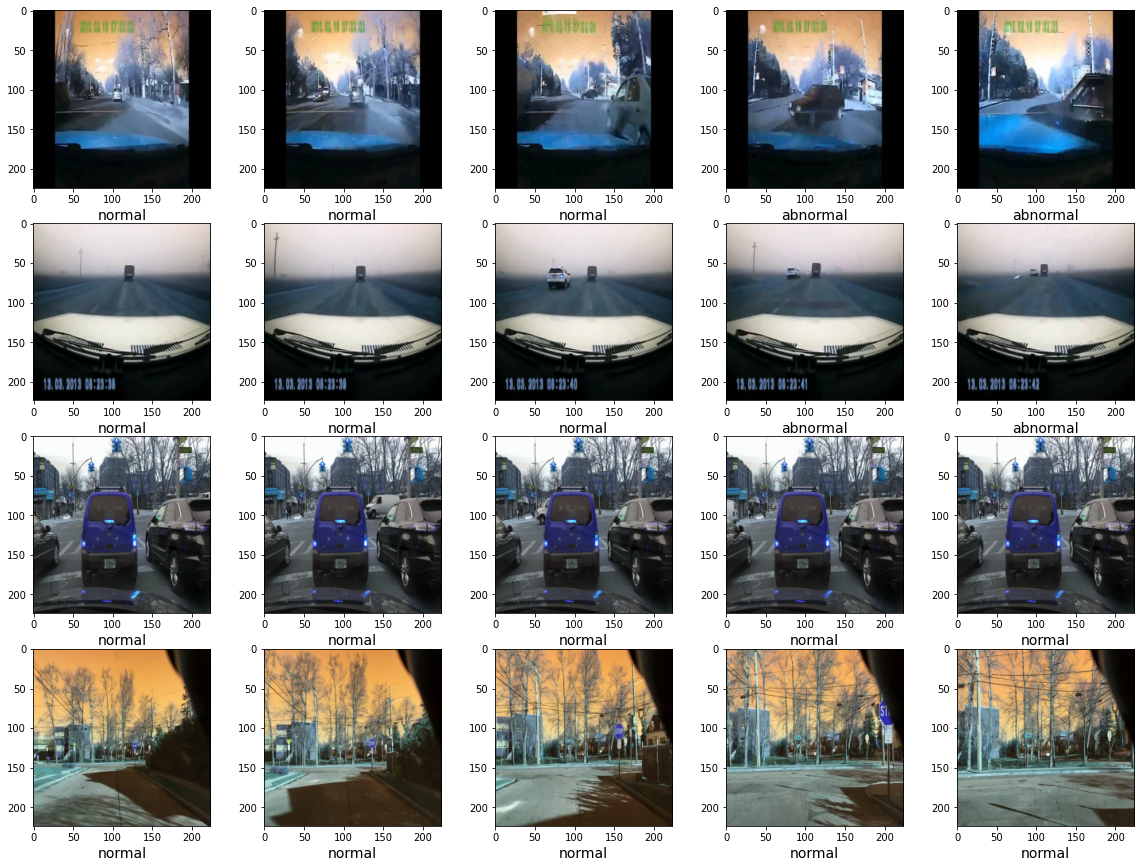

In [21]:
ABNORMAL_VIDEO_PATH = '/content/drive/MyDrive/road_accidents/abnormal/Crash-1500/'
ANNO_PATH = '/content/drive/MyDrive/road_accidents/'
NORMAL_VIDEO_PATH = '/content/drive/MyDrive/road_accidents/normal/Normal/'
abnormal_names = ['000001', '000100']
anno = ['normal', 'normal', 'normal', 'abnormal', 'abnormal']
i = 1
plt.figure(figsize=(20, 15))
for (k, name) in enumerate(abnormal_names):
    frames = get_video_frames(ABNORMAL_VIDEO_PATH + name + '.mp4', shape=(224, 224))
    for frame in frames[::10]:
        plt.subplot(4, 5, i)
        plt.imshow(frame)
        plt.xlabel(anno[i%5 - 1], fontsize=14)
        i += 1

normal_names = ['000001', '000100']

for name in normal_names:
    frames = get_video_frames(NORMAL_VIDEO_PATH + name + '.mp4', shape=(224, 224))
    for frame in frames[::10]:
        plt.subplot(4, 5, i)
        plt.imshow(frame)
        plt.xlabel('normal', fontsize=14)
        i += 1
plt.savefig('/content/dataset.png')

# Инициализация Inception v3

In [4]:
#-------INCEPTION V3 для извлечения признаков----------------
inception_model = InceptionV3(include_top=False, 
                              weights='imagenet',
                              input_shape=(224, 224, 3),
                              pooling='avg')
#-------------------------------------------------------

87916544/87910968 [==============================] - 1s 0us/step


# Обработка видео и извлечение признаков:



In [14]:
ABNORMAL_VIDEO_PATH = '/content/drive/MyDrive/road_accidents/abnormal/Crash-1500/'
ANNO_PATH = '/content/drive/MyDrive/road_accidents/'
NUMPY_ABNORMAL_PATH = '/content/drive/MyDrive/road_accidents/numpy_abnormal/'
VIDEO_LIMIT = 1000


#------------извлечение признаков из аномальных видео---------------------------------
annotations = read_anno_file(ANNO_PATH + 'abnormal_annotations.txt') # аномальные аннотации
counter_of_videos = 0
i = 0

with open(NUMPY_ABNORMAL_PATH + 'numpy_abnormal_features', 'wb') as numpy_abnormal:

    while counter_of_videos <= VIDEO_LIMIT: # чтение видео файлов

        i += 1
        videofile_name = '0'*(6 - len(str(i))) + str(i) + '.mp4'

        if annotations[i - 1]['lighting'] == 'Day':
            counter_of_videos += 1
            clear_output(wait=True)
            print(videofile_name)
            frames = get_video_frames(ABNORMAL_VIDEO_PATH + videofile_name, shape=(224, 224))
            accident_only_frames = get_accident_frames_only(frames, annotations[i - 1]['label'])

            features = inception_model.predict(accident_only_frames) #извлечение признаков

            # np.save(numpy_abnormal, features)



001143.mp4


In [14]:
#------------извлечение признаков из омальных видео-----------------------------------
NORMAL_VIDEO_PATH = '/content/drive/MyDrive/road_accidents/normal/Normal/'
NUMPY_NORMAL_PATH = '/content/drive/MyDrive/road_accidents/numpy_normal/'
ANNO_PATH = '/content/drive/MyDrive/road_accidents/'
VIDEO_LIMIT = 1000
DAY = 1
normal_annotations = np.loadtxt(ANNO_PATH + 'normal-annotations.txt', delimiter=',')[:, 1] # аномальные аннотации
counter_of_videos = 0
i = 0      
with open(NUMPY_NORMAL_PATH + 'numpy_normal_features', 'wb') as numpy_normal:

    while counter_of_videos <= VIDEO_LIMIT: # чтение видео файлов

        i += 1
        videofile_name = '0'*(6 - len(str(i))) + str(i) + '.mp4'

        if normal_annotations[i - 1] == DAY:
            counter_of_videos += 1
            
            frames = np.array(get_video_frames(NORMAL_VIDEO_PATH + videofile_name, shape=(224, 224)))
            clear_output(wait=True)
            print(videofile_name, ' shape = ', frames.shape)
            features = inception_model.predict(frames) #извлечение признаков

            np.save(numpy_normal, features)
        

001866.mp4  shape =  (50, 224, 224, 3)


# Файл с аннотациями для ДТП

In [5]:
dataframe_annotations = pd.DataFrame(annotations)
dataframe_annotations.head()

,vid,label,startframe,vid_ytb,lighting,weather,ego_involve
0,000001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",000285,0000,Day,Normal,Yes
1,000002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",000646,0000,Day,Normal,Yes
2,000003,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",000972,0000,Day,Normal,Yes
3,000004,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",001257,0000,Day,Normal,Yes
4,000005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",000462,0010,Day,Snowy,Yes


In [6]:
ABNORMAL_PATH = '/content/drive/MyDrive/road_accidents/numpy_abnormal/numpy_abnormal_features'
MASKED_ABNORMAL_PATH = '/content/drive/MyDrive/road_accidents/numpy_abnormal/numpy_masked_abnormal_features'

abnormal_features = load_features(ABNORMAL_PATH)

In [7]:
zero_padding = np.zeros(2048, dtype=np.float32)
abnormal_list = []
# with open(MASKED_ABNORMAL_PATH, 'wb') as numpy_masked_abnormal:

for video in abnormal_features: 
    masked_list = []
    for i in range(50-video.shape[0]):
        masked_list.append(zero_padding)
    for feature in video:
        masked_list.append(feature)
    # print(np.array(masked_list, dtype=np.object).shape)
    abnormal_list.append(np.array(masked_list, dtype=np.float32))
abnormal_array = np.array(abnormal_list)

In [8]:
NORMAL_PATH = '/content/drive/MyDrive/road_accidents/numpy_normal/numpy_normal_features'
normal_features = load_features(NORMAL_PATH)

In [9]:
normal_features = np.delete(normal_features, 357, 0)

In [10]:
X = []
for video in abnormal_array[:-1]:
    X.append(video)
for video in normal_features:
    X.append(video)
X = np.array(X)

In [11]:
Y = np.concatenate((np.ones(999, dtype=np.float32), 
                         np.zeros(999, dtype=np.float32)))

In [12]:
Y = keras.utils.to_categorical(Y, num_classes=2)

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, test_size=0.5)

# Проектирование реккурентной сети на основе независимых реккурентных слоев (indRNN)

In [62]:
TIME_STEPS = 50
FEATURE_SIZE = 2048
RECURRENT_MAX = pow(2, 1 / TIME_STEPS)
BATCH_SIZE = 50
NUM_UNITS = 128
input_shape = (BATCH_SIZE, TIME_STEPS, FEATURE_SIZE)
first_input_init = tf.random_uniform_initializer(-RECURRENT_MAX,
                                                  RECURRENT_MAX)
indrnn_layer = IndRNNCell(NUM_UNITS, recurrent_max_abs=RECURRENT_MAX,
                          recurrent_kernel_initializer=first_input_init)

rnn_model = keras.Sequential()
rnn_model.add(Input(shape=input_shape[1:]))
rnn_model.add(Masking())
rnn_model.add(RNN(indrnn_layer))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dense(2, activation='softmax'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


In [14]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 50, 2048)          0         
_________________________________________________________________
rnn (RNN)                    (None, 128)               262400    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 279,170
Trainable params: 279,170
Non-trainable params: 0
_________________________________________________________________


In [63]:
train_hist = rnn_model.fit(np.asarray(X_train), np.asarray(Y_train), batch_size=50, verbose=1, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


20/20 [==============================] - 4s 121ms/step - loss: 10.9376 - accuracy: 0.6751 - auc: 0.6775
Epoch 2/10
20/20 [==============================] - 2s 120ms/step - loss: 0.0304 - accuracy: 0.9977 - auc: 0.9979
Epoch 3/10
20/20 [==============================] - 2s 122ms/step - loss: 0.0107 - accuracy: 0.9969 - auc: 0.9969
Epoch 4/10
20/20 [==============================] - 2s 120ms/step - loss: 0.0058 - accuracy: 0.9987 - auc: 1.0000
Epoch 5/10
20/20 [==============================] - 2s 121ms/step - loss: 0.0082 - accuracy: 0.9980 - auc: 0.9980
Epoch 6/10
20/20 [==============================] - 2s 121ms/step - loss: 2.3138e-04 - accuracy: 1.0000 - auc: 1.0000
Epoch 7/10
20/20 [==============================] - 2s 123ms/step - loss: 5.3010e-04 - accuracy: 1.0000 - auc: 1.0000
Epoch 8/10
20/20 [==============================] - 2s 120ms/step - loss: 2.1371e-04 - accuracy: 1.0000 - auc: 1.0000
Epoch 9/10
20/20 [==============================] - 2s 121ms/step - loss: 1.2516e-04 -

In [64]:
test_hist = rnn_model.evaluate(X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


32/32 [==============================] - 2s 39ms/step - loss: 0.0541 - accuracy: 0.9950 - auc: 0.9960


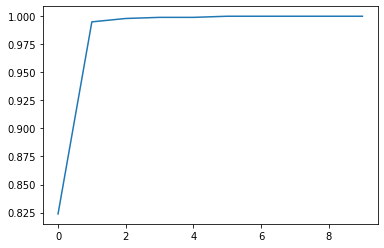

In [65]:
plt.plot(train_hist.history['accuracy'], label='train')


# Матрица ошибок

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


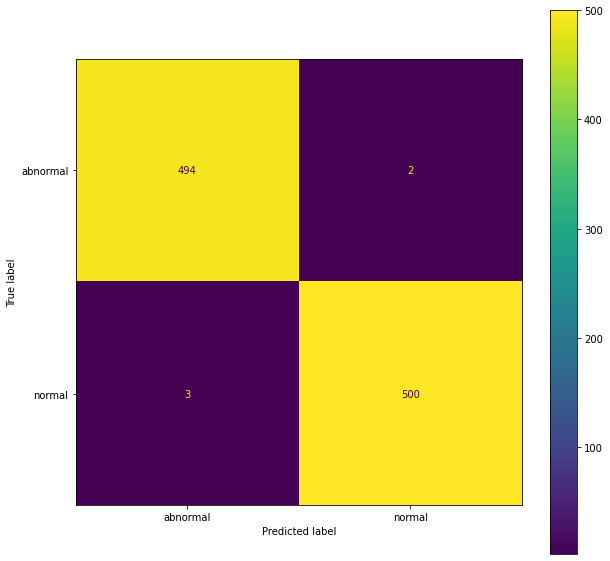

In [66]:
Y_true = np.argmax(Y_test, axis=-1)
Y_predicted = np.argmax(rnn_model.predict(X_test), axis=-1)
conf_mat = confusion_matrix(Y_true, Y_predicted)
fig, ax = plt.subplots(figsize=(10, 10))
disp_conf = ConfusionMatrixDisplay(conf_mat, ['abnormal', 'normal'])
disp_conf.plot(ax=ax, values_format='d')

# ROC-кривая

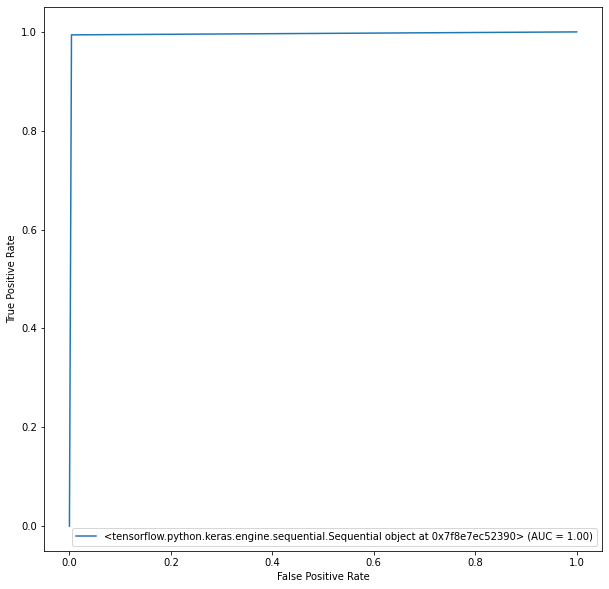

In [67]:
fpr, tpr, thresholds = roc_curve(Y_true, np.argmax(rnn_model.predict(X_test), axis=-1))
roc_auc = auc(fpr, tpr)
roc_fig, roc_ax = plt.subplots(figsize=(10, 10))
RocCurveDisplay(fpr, tpr, roc_auc, rnn_model).plot(ax=roc_ax)